# Spacing with Countershapes

This is an experimental contribution to research into automated font spacing.
The aim is not just to provide sidebearing values (e.g. spacing a glyph against
"H" or "n", which is what we often refer to as "spacing") but also to be able
to determine the optimal spacing value between an arbitrary pair of glyphs.
(what we often refer to as "kerning")

As mentioned, it is an experimental contribution. Please don't expect to be able
to use it to fully space and kern your fonts yet. At this stage, its purpose is
to help develop our understanding of problems in spacing and autospacing.

In [1]:
#%matplotlib notebook
from CounterSpace import CounterSpace
import matplotlib.pyplot as plt
CounterSpace.get_sample_font("OpenSans-Regular.ttf")
c = CounterSpace("OpenSans-Regular.ttf",serif_smoothing=0)

The basic conceit of CounterSpace is that well-spaced fonts have equal areas of "influence" in the counters between two glyphs. The problem is defining what we mean by influence.

For previous equal-area spacers such as [HTLetterSpacer](https://github.com/huertatipografica/HTLetterspacer), the area of influence is just the whitespace area between two glyphs. (There are several refinements HTLetterSpacer makes to this statement, but go with it for now, please.)

We can emulate this approach in CounterSpace. Here are the whitespace counters between "HH", and "OO", together with their respective areas:

Text(0.5, 1.0, '4179.884095252702')

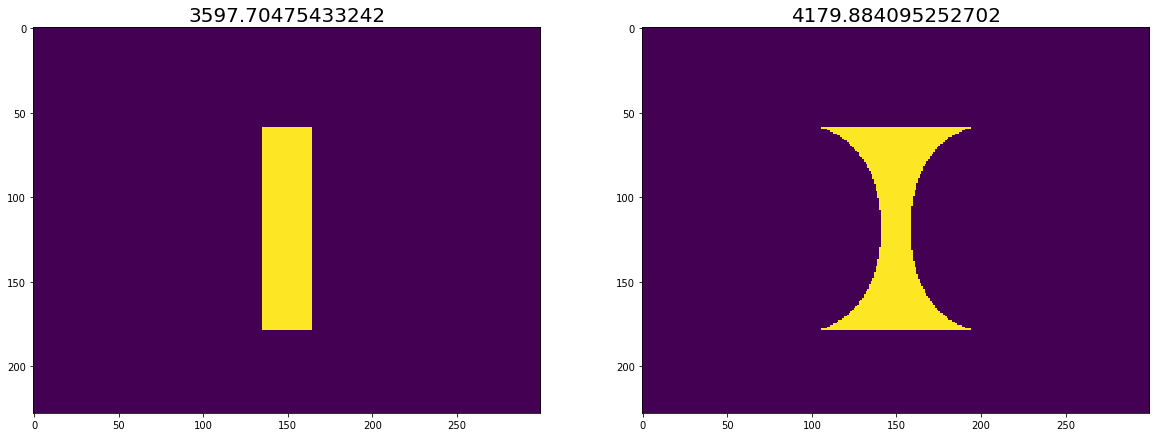

In [2]:
c.options = { "h_center": 1000, "w_center": 1000, "h_top":1, "w_top": 1, "h_bottom":1, "w_bottom": 1, "top_strength":0.1, "bottom_strength":0.1, "center_strength":1 }
fig, ax = plt.subplots(1,2,figsize = (20,20))
hh = c.pair_area("H","H",c.options)
oo = c.pair_area("O","O",c.options)
ax[0].imshow(hh)
ax[0].set_title(hh.sum(),fontsize=20)
ax[1].imshow(oo)
ax[1].set_title(oo.sum(),fontsize=20)

Oh, well. The areas aren't actually the same between our two reference pairs. HTLetterSpacer deals with this by having a parameter which determines how "deep" to descend into the counters. This cuts off the long tails around the corners of "OO"'s counter, reducing its area to the same as that of "HH". (That was one of the refinements I mentioned. We will deal with another one later.)

CounterSpace deals with the problem a different way. Our intuition is that the eye perceives the space in the center of a counter more strongly than around the edges. In other words, rather than our counterspace being a solid block as in the diagrams above, it's more like a light radiating outwards from the center. I don't believe it's literally a light source, but that gives us a useful metaphor to model what correct spacing looks like:

Text(0.5, 1.0, '2713.8562108570372')

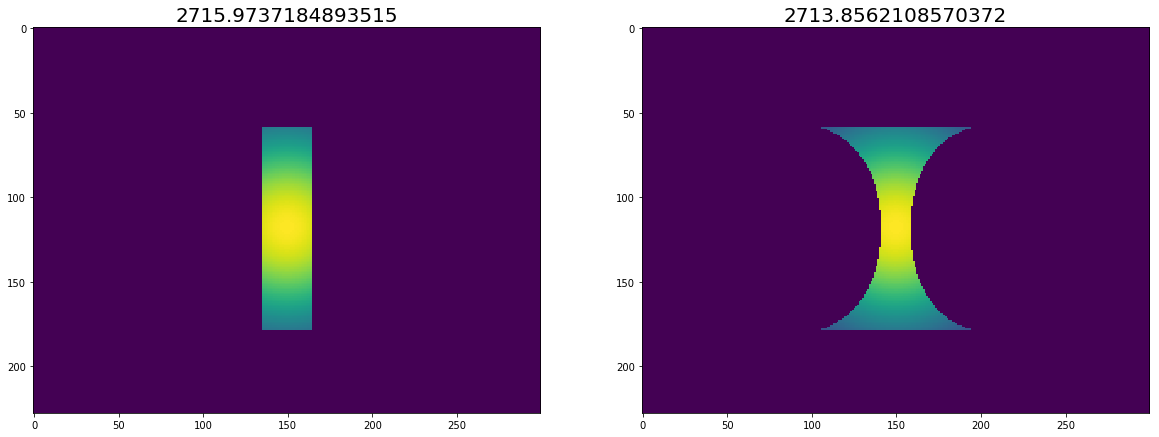

In [3]:
c.options = { "h_center": 45, "w_center": 45, "h_top":1, "w_top": 1, "h_bottom":1, "w_bottom": 1, "top_strength":0.1, "bottom_strength":0.1, "center_strength":1 }
fig, ax = plt.subplots(1,2,figsize = (20,20))
hh = c.pair_area("H","H",c.options)
oo = c.pair_area("O","O",c.options)
ax[0].imshow(hh)
ax[0].set_title(hh.sum(),fontsize=20)
ax[1].imshow(oo)
ax[1].set_title(oo.sum(),fontsize=20)

Now that's better. The total intensity of light is extremely similar between our two reference values. We can now take an arbitrary pair of glyphs, and change the distance between them until the intensity matches our expected total. 

VO distance should be set to 36 units


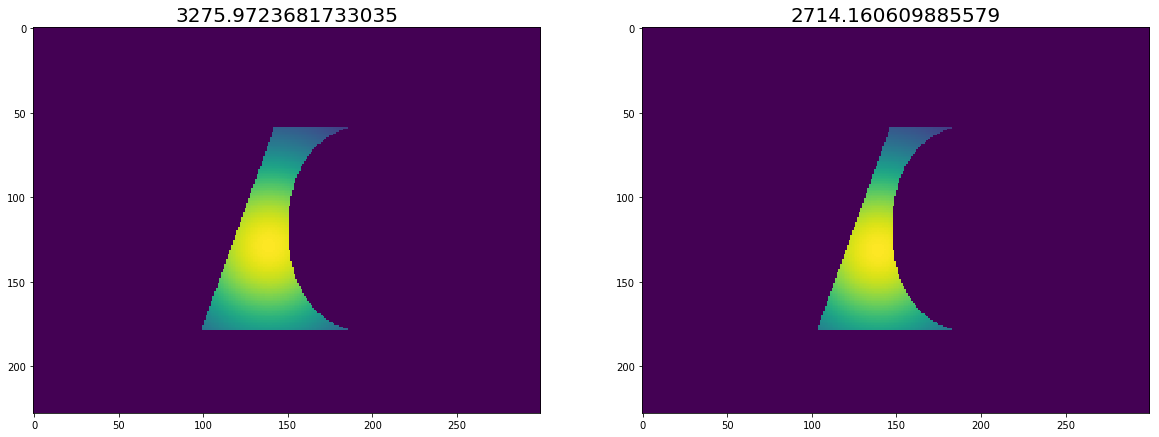

In [4]:
fig, ax = plt.subplots(1,2,figsize = (20,20))
VO = c.pair_area("V","O",c.options)
distance = 3
VO_corrected = c.pair_area("V","O",c.options,dist=distance)
ax[0].imshow(VO)
ax[0].set_title(VO.sum(),fontsize=20)
ax[1].imshow(VO_corrected)
ax[1].set_title(VO_corrected.sum(),fontsize=20)
distance_in_font_units = (distance/c.font.scale_factor)
print("VO distance should be set to %i units" % distance_in_font_units)

Note that the distance here refers to the ink-to-ink distance between the right edge of "V" and the left edge of "O" - essentially, the "total sidebearing" of the pair. To go from this to a kerning value, sum the actual right sidebearing and left sidebearing, and subtract from our desired difference:

In [5]:
rofV = c.font.glyph("V").rsb
lofO = c.font.glyph("O").lsb
natural_ink_to_ink = (rofV + lofO) / c.font.scale_factor
kern_required = int(distance_in_font_units - natural_ink_to_ink)
print(kern_required)

-85


What you should notice about this is that it is clearly wrong. The diagram on the left above (which sets the pair at the distance provided by the font, *including* the font's kerning adjustment of -20 units) is correctly spaced, and the one on the right is way too tight, even though the light intensity is equal to the reference pairs.

What's gone wrong? Well, it could be a number of things. One is that we set the intensity of our light source to be a circular light of 50 units across. Maybe an oval-shaped light would be better:

Text(0.5, 1.0, '2796.924826288794')

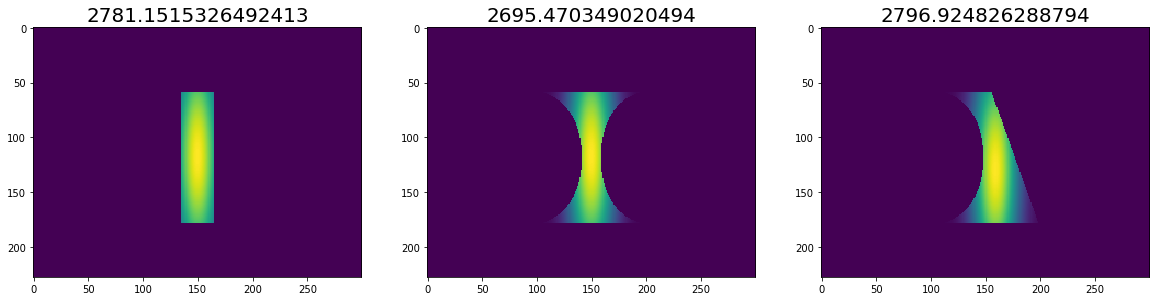

In [6]:
c.options = { "h_center": 75, "w_center": 15, "h_top":1, "w_top": 1, "h_bottom":1, "w_bottom": 1, "top_strength":0.1, "bottom_strength":0.1, "center_strength":1 }
fig, ax = plt.subplots(1,3,figsize = (20,20))
hh = c.pair_area("H","H",c.options)
oo = c.pair_area("O","O",c.options)
ov = c.pair_area("O","V",c.options)
ax[0].imshow(hh)
ax[0].set_title(hh.sum(),fontsize=20)
ax[1].imshow(oo)
ax[1].set_title(oo.sum(),fontsize=20)
ax[2].imshow(ov)
ax[2].set_title(ov.sum(),fontsize=20)

Well, that looks like it might be a slightly better set of parameters. The influence isn't exactly equal, but it's more consistent across correctly-spaced pairs than we had before.

One thing I want you to hold in your head at this stage is that I have manually searched for a set of parameters of lightsource width, height and intensity, so that the three pairs I am interested in ("HH", "OO", "OV") will ideally have equal total influence. But there's no reason why I should have to do this manually. What we will do later is say to the computer, "I declare that the following set of pairs are correctly spaced. Now search for the set of parameters which equalizes the influence between these pairs,* and we'll see how that works for other glyphs." This is something we can easily use an optimizer to do, and provides us with a nice interface to the type designer. "I've done these, you fill in the rest." "No, you got that one wrong. I'll space it manually, then declare that it is correct, and you can try again."

<small>*: Technically, which minimizes the square of the differences between the total influence of each of these pairs. This means we have a mean-square-error input to an optimizer, which computationally is a solved problem.</small>

CounterSpace also brings in another intuition, which provides us with more knobs to twiddle. This is taken from an idea found in Jost Hochuli's *Detail in Typography*. He introduces the metaphor of light flowing from below and above the counterspace:

![hochuli's light idea](https://pbs.twimg.com/media/D-PInV6W4AATKHW?format=jpg)

Now Hochuli's idea is [disputed](https://twitter.com/justvanrossum/status/1145369505855672321), and it also doesn't tell us how much "stronger" this conceptual "top light" is from "bottom light". It also doesn't tell us how the top and and bottom ideas interact with our "center light" intution. But that doesn't actually matter. We can model three light sources, and combine them in arbitrary ways:

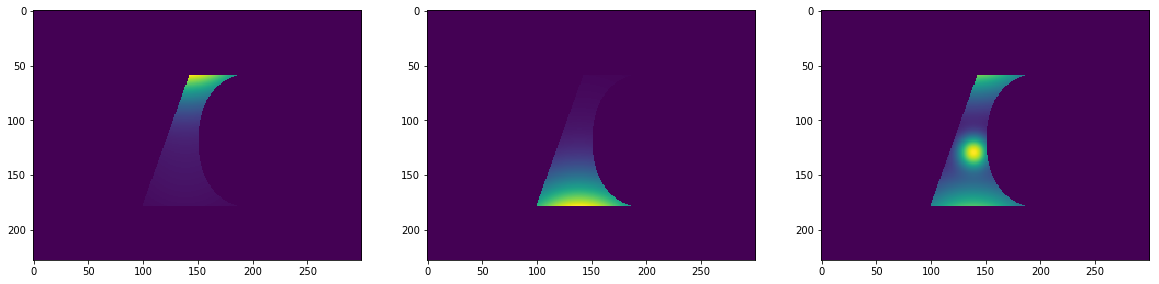

In [7]:
c.options = { "h_center": 50, "w_center": 50, "h_top":40, "w_top": 40, "h_bottom":40, "w_bottom": 40, "top_strength":5, "bottom_strength":0, "center_strength":0.1 }
fig, ax = plt.subplots(1,3,figsize = (20,20))
hh = c.pair_area("V","O",c.options)
c.options = { "h_center": 50, "w_center": 50, "h_top":40, "w_top": 40, "h_bottom":40, "w_bottom": 40, "top_strength":0, "bottom_strength":5, "center_strength":0.1 }
hh2 = c.pair_area("V","O",c.options)
c.options = { "h_center": 10, "w_center": 10, "h_top":40, "w_top": 40, "h_bottom":40, "w_bottom": 40, "top_strength":8, "bottom_strength":5, "center_strength":3 }
hh3 = c.pair_area("V","O",c.options)
ax[0].imshow(hh)
ax[1].imshow(hh2)
ax[2].imshow(hh3)

I've deliberately emphasised the effect in the parameters chosen above, but how strong should the influence of these lights be? Again, I don't care - now that we have our model, we can ask the computer to tell us the best parameters which equalize area. (This next cell takes quite a while to run.)

{'w_top': 15.419977486850728, 'w_bottom': 20.208110931511285, 'h_top': 16.24043686617071, 'h_bottom': 12.505802989022957, 'h_center': 50.0, 'w_center': 14.644407849180935, 'top_strength': 0.5021840542221542, 'bottom_strength': 0.8038162014633223, 'center_strength': 2.0323006307316973}


Text(0.5, 1.0, '5028.96319824444')

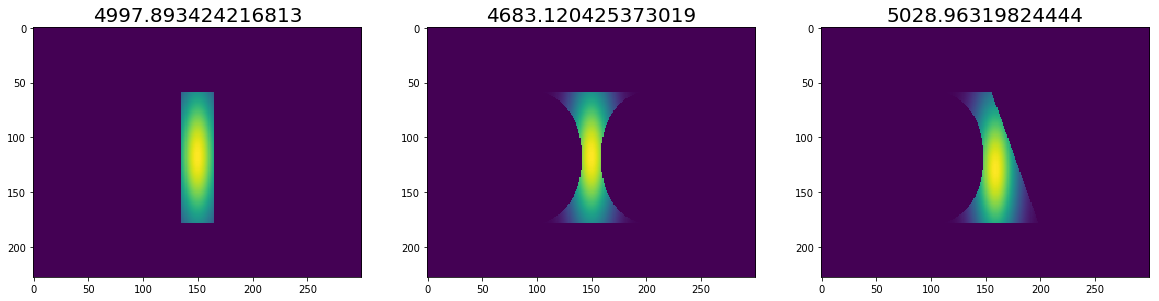

In [8]:
c.key_pairs = ["HH","OO","VO"]
print(c.determine_parameters())
fig, ax = plt.subplots(1,3,figsize = (20,20))
hh = c.pair_area("H","H",c.options)
oo = c.pair_area("O","O",c.options)
ov = c.pair_area("O","V",c.options)
ax[0].imshow(hh)
ax[0].set_title(hh.sum(),fontsize=20)
ax[1].imshow(oo)
ax[1].set_title(oo.sum(),fontsize=20)
ax[2].imshow(ov)
ax[2].set_title(ov.sum(),fontsize=20)

Eyeballing the diagrams above, it seems like top light and bottom light didn't contribute much in the case of this font. But the options are there for the computer to twiddle in case they do help.

CounterSpace brings two final refinements. One, also from HTLetterSpacer, is the idea of diagonizing the counters. The reason you have to do this is that some glyphs have insanely big counters, and that's OK. Not *all* of the counter should be considered as taking part in the spacing process.

Consider:

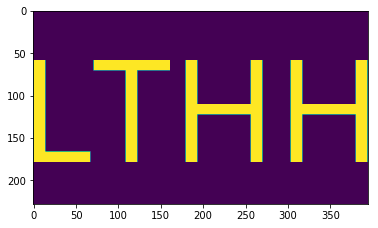

In [9]:
plt.imshow(c.font.set_string("LTHH"))

What's going to happen if we strictly enforce the principle that the total influence of "LT" should be equal to that of "HH"?

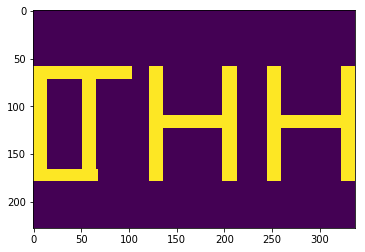

In [10]:
plt.imshow(c.font.set_string("LTHH",{("L","T"):-55})>0)

Yeah, oops. So instead, we look for glyphs which have deep "holes" in their outlines, and attempt to smoothly fill in those discontinuities:

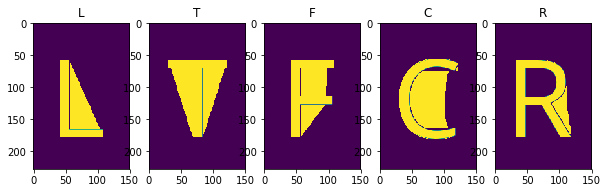

In [11]:
fig, ax = plt.subplots(1,5,figsize = (10,10))
for ix,s in enumerate("LTFCR"):
    l = c.font.glyph(s).as_matrix()
    conc = 1-l.right_face()
    ax[ix].imshow(l.reduce_concavity(conc).with_padding_to_constant_box_width(150))
    ax[ix].set_title(s)

There are two final refinements, which we will demonstrate together. The first is a small one to do with serifs. We apply a blur kernel to the outlines to remove the influence of serifs, which should not contribute to spacing decisions.

Text(0.5, 1.0, 'H (serif smoothing = 5)')

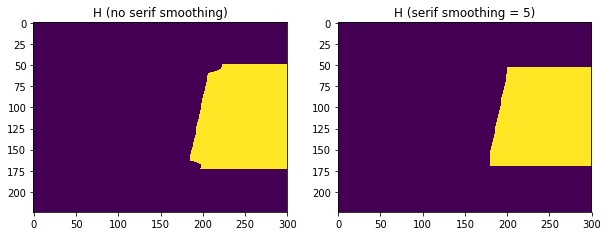

In [12]:
fig, ax = plt.subplots(1,2,figsize = (10,10))
CounterSpace.get_sample_font("PTSerif-Italic.ttf")
c = CounterSpace("PTSerif-Italic.ttf",serif_smoothing=0)
ax[0].imshow(c.lshifted_counter("H",0,50,200))
ax[0].set_title("H (no serif smoothing)")
c = CounterSpace("PTSerif-Italic.ttf",serif_smoothing=5)
ax[1].imshow(c.lshifted_counter("H",0,50,200))
ax[1].set_title("H (serif smoothing = 5)")

The second refinement happens automatically when you use an italic font: the light from the top and bottom is automatically angled to match:

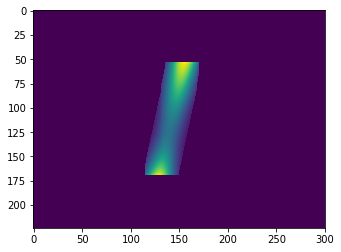

In [13]:
c.options = { "h_center": 50, "w_center": 50, "h_top":70, "w_top": 10, "h_bottom":40, "w_bottom": 10, "top_strength":2, "bottom_strength":3, "center_strength":0 }
plt.imshow(c.pair_area("H","H",c.options))

So now we have all the pieces required to space our font. Let us run the solver again, and use it to fill a dictionary with spacing values for pairs in a string. (The next cells take quite a long time.)

In [154]:
c = CounterSpace("PTSerif-Italic.ttf",serif_smoothing=5)
c.key_pairs = ["HH","OO"]
c.bare_minimum = 15
c.determine_parameters()

from itertools import tee
def pairwise(iterable):
  a, b = tee(iterable)
  next(b, None)
  return zip(a, b)

pdd = {} # Pair distance dictionary
def space_string(s):
  for l,r in pairwise(s):
    if not (l,r) in pdd: pdd[(l,r)] = int(c.space(l,r) * c.font.scale_factor)
  return c.font.set_string(s,pair_distance_dict = pdd) > 0

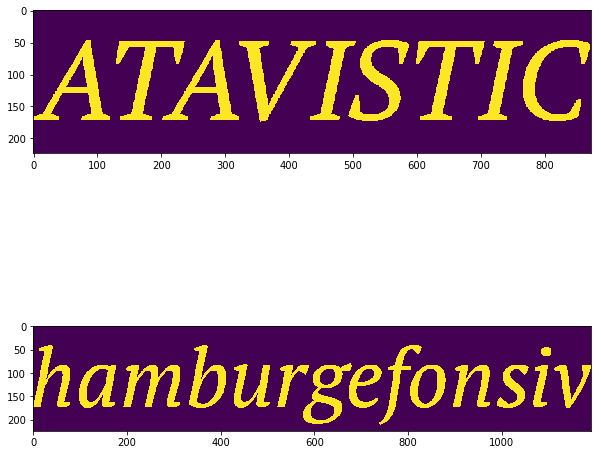

In [155]:
fig, ax = plt.subplots(2,1,figsize = (10,10))
ax[0].imshow(space_string("ATAVISTIC"))
ax[1].imshow(space_string("hamburgefonsiv"))

Well, not bad, I think. Where are the problems?

We brought in the idea of discontinuity smoothing because some deep countershapes (LT) had too much influence, and so their counters needed to be reduced. But the discontinuity smoothing process is hard to get right, and some counters (such as XX) now don't get enough influence (and so end up being spaced too wide, to compensate).

In the below, blue is the real metrics from the font, red is autospaced.

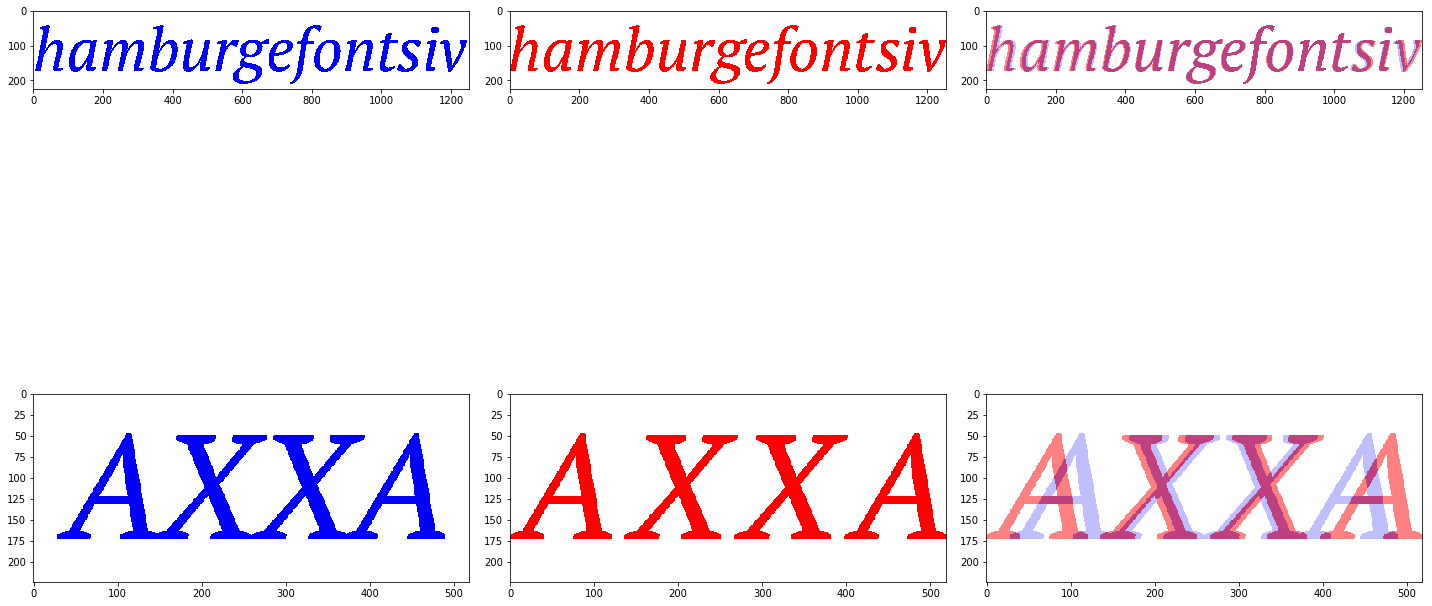

In [185]:
import numpy as np
import math
fig, ax = plt.subplots(2,3,figsize = (20,20))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
from matplotlib import colors
import numpy as np
cmap1 = colors.ListedColormap(['white', 'red'])
cmap2 = colors.ListedColormap(['white', 'blue'])
def comparison(s,ax):
    real = c.font.set_string(s)
    autospaced = space_string(s)
    diff1 = max(autospaced.shape[1]-real.shape[1],0)/2
    real = real.with_padding(math.floor(diff1),math.ceil(diff1)) > 0
    autospaced._glyph = None
    diff2 = max(real.shape[1]-autospaced.shape[1],0)/2
    autospaced = autospaced.with_padding(math.floor(diff2),math.ceil(diff2)) > 0
#     return real
    ax[0].imshow(real,cmap=cmap2)
    ax[1].imshow(autospaced,cmap=cmap1)
    ax[2].imshow(real,alpha=0.5,cmap=cmap2)
    ax[2].imshow(autospaced,alpha=0.5,cmap=cmap1)


comparison("hamburgefontsiv",ax[0])
comparison("FAXXAF",ax[1])
plt.tight_layout()

In [ ]:
Ideally, 